In [1]:
import os
import math
import time
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
import copy
import random

from torchvision import datasets, transforms
from sklearn.covariance import EmpiricalCovariance
from scipy.stats import multivariate_normal
from torch.distributions.multivariate_normal import MultivariateNormal
from autoattack import AutoAttack

root = 'Gaussian_results/'
if not os.path.isdir(root):
    os.mkdir(root)

In [2]:
def show_data(X):

    for idx in range(n_cls):
        X_curr = X[(idx*n_sample):((idx+1)*n_sample)]
        plt.scatter(X_curr[:, 0].T, X_curr[:, 1].T, color=color_list[idx], label='label : {}'.format(idx), s=35) 

    plt.grid(True)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)    
    plt.axis('equal')


In [3]:
def load_data(n_sample, variance): 
    
    X, Y = torch.Tensor(0, 2), torch.Tensor(0, 1)
    
    for i in range(3):
        for j in range(3):
            m = [-10 + 10 * i, -10 + 10 * j]
            cov =  np.array([[0.1, 0], [0, 0.1]]) * variance
            rng = np.random.RandomState(3 * j + i)
            X_ij = rng.multivariate_normal(mean=m, cov=cov, size=n_sample)
            
            X_ij = torch.from_numpy(X_ij)
            Y_ij = torch.ones(X_ij.size()[0], 1) * (3 * i + j)
            
            X = torch.cat([X, X_ij])
            Y = torch.cat([Y, Y_ij])
    
    X = X.float()
    Y = Y.long()
    print(X.size())
    show_data(X)
    return X, Y

## Visualize the training data

torch.Size([45000, 2])
torch.Size([45000, 2]) torch.Size([45000, 1])


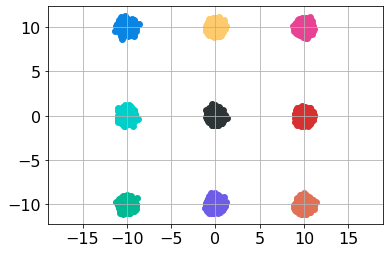

In [4]:
# Settings
feat_dim = 2
n_aug = 50
n_sample = 5000
show_plt = False
variance = 1
loss_lam = 1

color_list = ['#00b894', '#00cec9', '#0984e3', '#6c5ce7',  '#2d3436', '#fdcb6e', '#e17055', '#d63031', '#e84393']
background_list = ['#55efc4', '#81ecec', '#74b9ff', '#a29bfe', '#636e72', '#ffeaa7', '#fab1a0', '#ff7675', '#fd79a8']
soft_color_list = ['slategrey', 'slategrey', 'slategrey', 'indigo', 'maroon', 'darkseagreen']
all_shape=['.','o','v','^','>','<','s','p','*','h','H','D', 'd', '', '', '']
marker_shape=['^','v','>', '*', 'p', 'd']

# Load data
n_cls = 9
label_list = [i for i in range(n_cls)]
digit_list = label_list
data, label = load_data(n_sample = n_sample, variance = variance)
print(data.shape, label.shape)

## Mixup

In [5]:
def get_lambda(alpha=2.0):
    '''Return lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    return lam

In [6]:
def input_mixup(x, y, lam):

    batch_size = x.size()[0]

    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b

In [7]:
def mixup_criterion(y_a, y_b, lam):
    return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## GMLabel

## train the network


In [8]:
def seed(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [9]:
class SoftCrossEntropy(nn.Module):

    def __init__(self, reduction='mean'):
        super().__init__()
        self.reduction = reduction
        return

    def forward(self, inputs, target):
        log_likelihood = - F.log_softmax(inputs, dim=1)
        batch_size = target.size()[0]

        if self.reduction == "mean":
            loss = torch.sum(torch.mul(log_likelihood, target)) / batch_size
        elif self.reduction == "none":
            loss = torch.sum(torch.mul(log_likelihood, target), dim=-1)
        else:
            print('Fill in here')
            exit()
        return loss


In [10]:
class G_net(nn.Module):
    # initializers
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, n_cls)

    # forward method
    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x
    
    def latent(self, input):
        
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        return x
    
    def out(self, input):
        
        x = self.fc4(input)
        
        return x

In [11]:
def draw_figure(net, mode):

    rand_data = torch.rand((500000, 2)) * torch.tensor([[40, 40]]) - torch.tensor([[20, 20]])

    output = net(rand_data)
    _, predict = torch.max(output, dim=1)

    predict = predict.cpu()
    fig, axs = plt.subplots(1,1)

    
    for i in range(n_cls):
        data_i = rand_data[predict == i]
        plt.scatter(data_i[:, 0], data_i[:, 1], s=0.5, color=background_list[i])

    for i in range(n_cls):
        plt.scatter(data[n_sample * i:n_sample * (i + 1), 0], data[n_sample * i:n_sample * (i + 1), 1], color=color_list[i])

    plt.xlim(-20, 20)
    plt.ylim(-20, 20)
    axs.set_aspect('equal', 'box') 
    plt.xticks(fontsize=16)    
    plt.yticks(fontsize=16) 
    
    plt.savefig('Gaussian_results/G_shape_1x4_boundary_{}.png'.format(mode))

In [12]:
def cov(tensor, rowvar=True, bias=False):
    """Estimate a covariance matrix (np.cov)"""
    tensor = tensor if rowvar else tensor.transpose(-1, -2)
    tensor = tensor - tensor.mean(dim=-1, keepdim=True)
    factor = 1 / (tensor.shape[-1] - int(not bool(bias)))
    return torch.diag(factor * ((tensor.unsqueeze(-2) @ tensor.unsqueeze(-1)).squeeze() + torch.rand(tensor.shape[0]) * 1e-8))

In [13]:
def train(train_loader, test_loader, train_epoch, lr, mode, alpha):

    net = G_net()
    lossfunc = SoftCrossEntropy()
    optimizer = optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999))

    train_hist = {}
    train_hist['losses'] = []
    train_hist['per_epoch_ptimes'] = []
    train_hist['total_ptime'] = []
    
    best_net = None
    best_acc = 0

    print('Training start!')
    start_time = time.time()

    for epoch in range(train_epoch):
        losses = []
        epoch_start_time = time.time()

        if mode == 0: # mixup + GMLabel
            
            lossfunc = SoftCrossEntropy(reduction='none')
            
            for data, label in train_loader:

                net.zero_grad()

                feature = data

                # vanilla mixup
                batch_size = data.size(0)
                mix_lam = np.random.beta(1, 1)
                random_indices = torch.randperm(batch_size)
                mid_data = mix_lam * data + (1 - mix_lam) * data[random_indices]
                mix_label_1, mix_label_2 = label, label[random_indices]

                mid_feature_pack = mid_data
                feature_pack, label_pack, mean_pack = [], [], []

                for digit in digit_list:
                    feature_selected = feature[torch.max(label, dim=1)[1] == digit]
                    label_selected = label[torch.max(label, dim=1)[1] == digit]

                    if feature_selected.size(0) == 0:
                        continue

                    feature_pack.append(feature_selected)
                    label_pack.append(label_selected)

                    mean = torch.mean(feature_selected, dim=0, keepdim=True).detach()
                    mean_pack.append(mean)

                num_class = len(feature_pack)

                # prepare labels
                labels = []
                for label_selected in label_pack:
                    labels.append(label_selected[0:1])
                labels = torch.cat(labels)

                # prepare matrices
                feature_pack = torch.cat(feature_pack)
                mean_pack = torch.cat(mean_pack)
                label_pack = torch.cat(label_pack)

                # correct labels
                mean = mean_pack.unsqueeze(0).repeat(feature_pack.size(0), 1, 1)
                mid_feature = mid_feature_pack.detach().unsqueeze(1).repeat(1, num_class, 1)

                pdf = -0.5 * ((mid_feature - mean) ** 2).sum(dim=-1).squeeze()
                pdf_value, pdf_indices = torch.sort(pdf, dim=-1, descending=True)
                lam = 1 / (1 + torch.exp(pdf_value[:, 1] - pdf_value[:, 0]))

                # generate middle label
                mid_label_pack = labels.unsqueeze(0).repeat(feature_pack.size(0), 1, 1) \
                    .gather(dim=1, index=pdf_indices[:, 0:2].unsqueeze(-1).repeat(1, 1, labels.size(-1))).squeeze(1) \

                label_1 = mid_label_pack[:, 0]
                label_2 = mid_label_pack[:, 1]

                # continue training

                output = net(mid_feature_pack)

                loss_func_2 = mixup_criterion(mix_label_1, mix_label_2, mix_lam)
                loss_func_3 = mixup_criterion(label_1, label_2, lam)

                general_loss = loss_func_2(lossfunc, output).mean()
                gm_loss = loss_func_3(lossfunc, output).mean()

                loss = (1 - loss_lam) * general_loss + loss_lam * gm_loss

                loss.backward()
                optimizer.step()

                losses.append(loss.data.item())

        elif mode == 1: # pure mixup
            for data, label in train_loader:
                # mixup
                lam = get_lambda(alpha)
                data, label_a, label_b = input_mixup(data, label, lam)

                # forward
                net.zero_grad()
                output = net(data)

                loss_func_2 = mixup_criterion(label_a, label_b, lam)
                loss = loss_func_2(lossfunc, output)

                # backward
                loss.backward()
                optimizer.step()

                losses.append(loss.data.item())
                
        elif mode == 2: # vanilla
            for data, label in train_loader:
                # forward
                net.zero_grad()
                output = net(data)
                loss = lossfunc(output, label)

                # backward
                loss.backward()
                optimizer.step()
                losses.append(loss.data.item())

        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time

        print('[%d/%d] - ptime: %.2f, loss: %.6f' % ((epoch + 1),
            train_epoch, per_epoch_ptime,
            torch.mean(torch.FloatTensor(losses))))

        train_hist['losses'].append(torch.mean(torch.FloatTensor(losses)))
        train_hist['per_epoch_ptimes'].append(per_epoch_ptime)

        # test on test dataset every 10 epochs
        if (epoch + 1) % 1 == 0:
            acc = test(net, test_loader)
            if acc >= best_acc:
                best_net = copy.deepcopy(net)
                best_acc = acc

    end_time = time.time()
    total_ptime = end_time - start_time
    train_hist['total_ptime'].append(total_ptime)

    print("Avg one epoch ptime: %.2f, total %d epochs ptime: %.2f" % (
        torch.mean(torch.FloatTensor(train_hist['per_epoch_ptimes'])), train_epoch, total_ptime))
    print("Training finish!... save training results")

    return best_net

In [14]:
def test(net, test_loader):
    net.eval()

    total = 0
    correct = 0

    for data, label in test_loader:
        output = net(data)

        # convert labels
        _, predict = torch.max(output, dim=1)
        _, label = torch.max(label, dim=1)

        total += predict.size()[0]
        correct += (predict == label).sum()

    accuracy = correct.data.item() / total
    print("Testing accuracy: %.3f%%" % (accuracy * 100))

    net.train()

    return accuracy

In [15]:
def train_model(mode):
    alpha = 2.0

    if mode == 0: 
        num_fold = 4
    else:
        num_fold = 0
    
    batch_size = 1000
    lr = 0.001
    train_epoch = 10

    # load train data 
    train_data, train_label = data, label.view(-1)
    test_data, test_label = data_2, label_2.view(-1)
    
    onehot = torch.zeros(n_cls, n_cls).long()
    onehot = onehot.scatter_(1, torch.LongTensor(range(n_cls)).view(n_cls, 1), 1)
    train_label = onehot[train_label]
    test_label = onehot[test_label]

    train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data, train_label), batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_data, test_label), batch_size=batch_size, shuffle=True)
    
    # train the network
    best_net = train(train_loader, test_loader, train_epoch, lr, mode, alpha)

    return best_net

torch.Size([9000, 2])


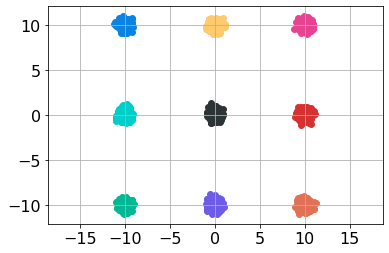

In [16]:
n_sample = 1000
data_2, label_2 = load_data(n_sample = n_sample, variance = variance)

In [17]:
mode = 0
seed(2)
best_net = train_model(mode) # 0 for mixup+GMLabel, 1 for mixup, 2 for vanilla

Training start!
[1/10] - ptime: 1.29, loss: 0.997826
Testing accuracy: 100.000%
[2/10] - ptime: 0.98, loss: 0.424150
Testing accuracy: 100.000%
[3/10] - ptime: 0.97, loss: 0.217606
Testing accuracy: 100.000%
[4/10] - ptime: 0.93, loss: 0.274362
Testing accuracy: 100.000%
[5/10] - ptime: 0.94, loss: 0.157739
Testing accuracy: 100.000%
[6/10] - ptime: 0.79, loss: 0.125004
Testing accuracy: 100.000%
[7/10] - ptime: 0.86, loss: 0.137979
Testing accuracy: 100.000%
[8/10] - ptime: 0.76, loss: 0.097265
Testing accuracy: 100.000%
[9/10] - ptime: 0.82, loss: 0.115467
Testing accuracy: 100.000%
[10/10] - ptime: 0.78, loss: 0.087789
Testing accuracy: 100.000%
Avg one epoch ptime: 0.91, total 10 epochs ptime: 10.09
Training finish!... save training results


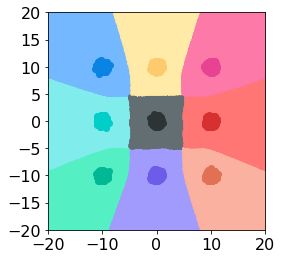

In [18]:
n_sample = 5000
draw_figure(best_net, mode)

In [19]:
mode = 1
seed(2)
best_net_2 = train_model(mode) # 0 for mixup+GMLabel, 1 for mixup, 2 for vanilla

Training start!
[1/10] - ptime: 0.79, loss: 1.467306
Testing accuracy: 99.978%
[2/10] - ptime: 0.62, loss: 1.279197
Testing accuracy: 100.000%
[3/10] - ptime: 0.60, loss: 1.297815
Testing accuracy: 100.000%
[4/10] - ptime: 0.56, loss: 1.248344
Testing accuracy: 100.000%
[5/10] - ptime: 0.78, loss: 1.167372
Testing accuracy: 100.000%
[6/10] - ptime: 0.77, loss: 1.250723
Testing accuracy: 100.000%
[7/10] - ptime: 0.71, loss: 1.363460
Testing accuracy: 100.000%
[8/10] - ptime: 0.72, loss: 1.192850
Testing accuracy: 100.000%
[9/10] - ptime: 0.78, loss: 1.177139
Testing accuracy: 100.000%
[10/10] - ptime: 0.72, loss: 1.190842
Testing accuracy: 100.000%
Avg one epoch ptime: 0.70, total 10 epochs ptime: 7.99
Training finish!... save training results


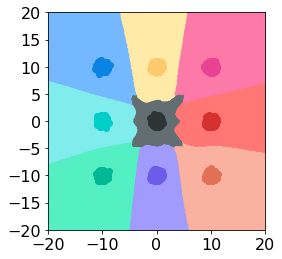

In [20]:
draw_figure(best_net_2, mode)

In [21]:
mode = 2
seed(2)
best_net_3 = train_model(mode) # 0 for mixup+GMLabel, 1 for mixup, 2 for vanilla

Training start!
[1/10] - ptime: 0.65, loss: 0.635554
Testing accuracy: 100.000%
[2/10] - ptime: 0.77, loss: 0.060146
Testing accuracy: 100.000%
[3/10] - ptime: 0.56, loss: 0.001782
Testing accuracy: 100.000%
[4/10] - ptime: 0.62, loss: 0.000743
Testing accuracy: 100.000%
[5/10] - ptime: 0.53, loss: 0.000479
Testing accuracy: 100.000%
[6/10] - ptime: 0.58, loss: 0.000339
Testing accuracy: 100.000%
[7/10] - ptime: 0.61, loss: 0.000240
Testing accuracy: 100.000%
[8/10] - ptime: 0.63, loss: 0.000180
Testing accuracy: 100.000%
[9/10] - ptime: 0.67, loss: 0.000143
Testing accuracy: 100.000%
[10/10] - ptime: 0.62, loss: 0.000116
Testing accuracy: 100.000%
Avg one epoch ptime: 0.62, total 10 epochs ptime: 7.30
Training finish!... save training results


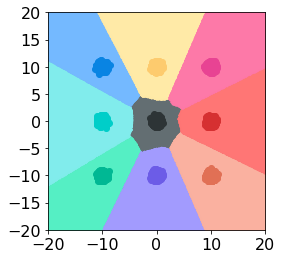

In [22]:
draw_figure(best_net_3, mode)